# Transformer 한영 번역 모델

## 0. Setup & Installation

In [ ]:
!pip install -q sacrebleu sentencepiece transformers

--2025-11-27 12:26:38--  https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/fonts/main/ofl/nanumgothic/NanumGothic-Regular.ttf [following]
--2025-11-27 12:26:38--  https://raw.githubusercontent.com/google/fonts/main/ofl/nanumgothic/NanumGothic-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2054744 (2.0M) [application/octet-stream]
Saving to: ‘NanumGothic-Regular.ttf.4’

NanumGothic-Regular 100%[===================>]   1.96M  --.-KB/s    in 0.009s  

2025-11-27 12:26:38 (210 MB/s) - ‘NanumGothic-

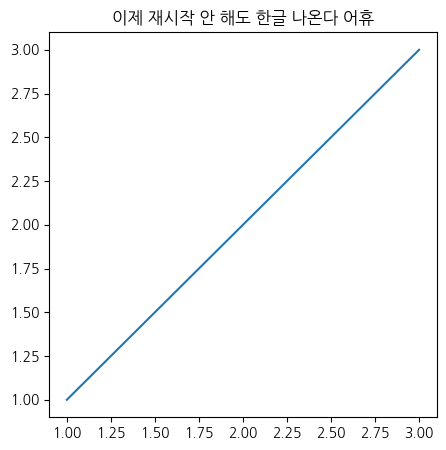

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

!wget 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'

fm.fontManager.addfont('NanumGothic-Regular.ttf')

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(5,5))
plt.plot([1, 2, 3], [1, 2, 3])
plt.title('이제 재시작 안 해도 한글 나온다 어휴')
plt.show()

## 1. Configuration

In [4]:
import os
import re
import math
import time
import random
from typing import List, Tuple, Dict, Optional
from collections import Counter
from dataclasses import dataclass

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import sentencepiece as spm
import sacrebleu
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')

In [5]:
# CONFIGURATION
@dataclass
class Config:
    """모든 설정을 담는 Configuration 클래스"""

    # === Paths ===
    data_dir: str = './data'
    model_dir: str = './models'
    tokenizer_dir: str = './tokenizers'

    # === Data ===
    train_ratio: float = 0.8
    val_ratio: float = 0.1
    test_ratio: float = 0.1
    max_length_src: int = 80     # Korean
    max_length_tgt: int = 70     # English
    vocab_size_src: int = 16000  # Korean vocab
    vocab_size_tgt: int = 16000  # English vocab
    batch_size: int = 256
    num_workers: int = 0

    # === Model ===
    emb_dim: int = 256
    ffn_dim: int = 1024
    num_heads: int = 4
    num_layers: int = 4
    dropout: float = 0.1

    # === Training ===
    num_epochs: int = 100
    learning_rate: float = 1.0
    warmup_steps: int = 4000
    label_smoothing: float = 0.1
    clip_grad: float = 1.0
    patience: int = 10
    min_delta: float = 0.001

    # === Decoding ===
    beam_size: int = 5
    length_penalty: float = 0.6

    # === Debug ===
    debug_interval: int = 10

    # === Back-translation ===
    use_back_translation: bool = True
    bt_ratio: float = 0.3

    # === Seed ===
    seed: int = 42

    @property
    def max_length(self) -> int:
        return max(self.max_length_src, self.max_length_tgt)

    @property
    def eng_train_path(self) -> str:
        return f'{self.data_dir}/korean-english-park.train.en'

    @property
    def kor_train_path(self) -> str:
        return f'{self.data_dir}/korean-english-park.train.ko'

    @property
    def model_save_path(self) -> str:
        return f'{self.model_dir}/transformer_ko_en.pt'

    @property
    def kor_tokenizer_prefix(self) -> str:
        return f'{self.tokenizer_dir}/sp_kor'

    @property
    def eng_tokenizer_prefix(self) -> str:
        return f'{self.tokenizer_dir}/sp_eng'


# Initialize config
cfg = Config()

# Create directories
os.makedirs(cfg.model_dir, exist_ok=True)
os.makedirs(cfg.tokenizer_dir, exist_ok=True)

# Set device
device = torch.device(
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else 'cpu'
)

# Set random seed
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)

print(f"Device: {device}")
print(f"Model: {cfg.emb_dim}d, {cfg.num_layers}L, {cfg.num_heads}H")
print(f"Training: {cfg.num_epochs} epochs, batch={cfg.batch_size}, warmup={cfg.warmup_steps}")

Device: cuda
Model: 256d, 4L, 4H
Training: 100 epochs, batch=256, warmup=4000


## 2. Data Loading & Preprocessing

In [6]:
def load_data(eng_path: str, kor_path: str) -> Tuple[List[str], List[str]]:
    """Load Korean-English parallel corpus"""
    with open(eng_path, 'r', encoding='utf-8') as f:
        eng_sentences = [line.strip() for line in f if line.strip()]
    with open(kor_path, 'r', encoding='utf-8') as f:
        kor_sentences = [line.strip() for line in f if line.strip()]

    assert len(eng_sentences) == len(kor_sentences), "Sentence count mismatch!"
    print(f"Loaded {len(eng_sentences):,} sentence pairs")
    return eng_sentences, kor_sentences


def preprocess_sentence(sentence: str, lang: str = 'eng') -> str:
    """Preprocess a single sentence"""
    sentence = sentence.strip()
    if lang == 'eng':
        sentence = sentence.lower()
    sentence = re.sub(r"\s+", " ", sentence)
    return sentence.strip()

## 2.5 탐색적 데이터 분석 (EDA)

In [7]:
def perform_eda(eng_sentences: List[str], kor_sentences: List[str],
                min_eng_words: int = 3, max_eng_words: int = 50,
                min_kor_words: int = 2, max_kor_words: int = 60) -> pd.DataFrame:
    """영어-한국어 병렬 코퍼스에 대한 탐색적 데이터 분석"""
    print("=" * 60)
    print("탐색적 데이터 분석 (EDA)")
    print("=" * 60)

    eng_processed = [preprocess_sentence(s, 'eng') for s in tqdm(eng_sentences, desc="영어 전처리")]
    kor_processed = [preprocess_sentence(s, 'kor') for s in tqdm(kor_sentences, desc="한국어 전처리")]

    df = pd.DataFrame({'eng': eng_processed, 'kor': kor_processed})
    print(f"\n원본 데이터: {len(df):,} 문장 쌍")

    # 1. 중복 제거
    print(f"\n[1] 중복 분석")
    num_duplicates = df.duplicated().sum()
    print(f"  중복된 문장 쌍: {num_duplicates:,}")
    if num_duplicates > 0:
        df = df.drop_duplicates().reset_index(drop=True)
        print(f"  중복 제거 후: {len(df):,}")

    # 2. 결측치 확인
    print(f"\n[2] 결측치 분석")
    missing = (df['eng'] == '').sum() + (df['kor'] == '').sum() + df.isna().sum().sum()
    if missing > 0:
        df = df[(df['eng'] != '') & (df['kor'] != '')].dropna().reset_index(drop=True)
        print(f"  결측치 제거: {missing:,}개")
    else:
        print("  결측치 없음")

    # 3. 길이 필터링
    print(f"\n[3] 길이 필터링")
    df['eng_len'] = df['eng'].apply(lambda x: len(x.split()))
    df['kor_len'] = df['kor'].apply(lambda x: len(x.split()))
    before_filter = len(df)
    df = df[(df['eng_len'] >= min_eng_words) & (df['eng_len'] <= max_eng_words) &
            (df['kor_len'] >= min_kor_words) & (df['kor_len'] <= max_kor_words)].reset_index(drop=True)
    print(f"  기준: 영어 {min_eng_words}-{max_eng_words}단어, 한국어 {min_kor_words}-{max_kor_words}단어")
    print(f"  필터링 후: {len(df):,} (제거: {before_filter - len(df):,})")

    # 4. 이상치 제거
    print(f"\n[4] 이상치 탐지 (길이 비율)")
    df['ratio'] = df['eng_len'] / df['kor_len'].replace(0, np.nan)
    outlier_mask = (df['ratio'] > 5) | (df['ratio'] < 0.2) | (df['ratio'].isna())
    num_outliers = outlier_mask.sum()
    if num_outliers > 0:
        print(f"  이상치: {num_outliers:,}개")
        df = df[~outlier_mask].reset_index(drop=True)

    # 5. 통계
    print(f"\n[5] 최종 데이터 통계")
    for lang, col in [('영어', 'eng_len'), ('한국어', 'kor_len')]:
        stats = df[col].describe(percentiles=[0.5, 0.95, 0.99])
        print(f"  {lang}: 평균={stats['mean']:.1f}, 중앙값={stats['50%']:.1f}, 최대={stats['max']:.0f}")

    # 시각화
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    axes[0].hist(df['eng_len'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].axvline(df['eng_len'].quantile(0.99), color='red', linestyle='--', label='99%ile')
    axes[0].set_xlabel('단어 수')
    axes[0].set_ylabel('빈도')
    axes[0].set_title('영어 문장 길이 분포')
    axes[0].legend()

    axes[1].hist(df['kor_len'], bins=50, color='coral', alpha=0.7, edgecolor='black')
    axes[1].axvline(df['kor_len'].quantile(0.99), color='red', linestyle='--', label='99%ile')
    axes[1].set_xlabel('단어 수')
    axes[1].set_ylabel('빈도')
    axes[1].set_title('한국어 문장 길이 분포')
    axes[1].legend()

    axes[2].scatter(df['eng_len'], df['kor_len'], alpha=0.1, s=5)
    axes[2].set_xlabel('영어 단어 수')
    axes[2].set_ylabel('한국어 단어 수')
    axes[2].set_title('문장 길이 상관관계')

    plt.tight_layout()
    plt.show()

    print(f"\n" + "=" * 60)
    print(f"EDA 완료: {len(eng_sentences):,} -> {len(df):,} 문장 쌍")
    print("=" * 60)
    return df[['eng', 'kor']]

## 3. 데이터 증강: Back-Translation

In [8]:
def back_translate_augmentation(
    sentences: List[str],
    ratio: float = 0.1,
    batch_size: int = 16) -> Tuple[List[str], List[int]]:
    """
    Back-translation을 사용한 데이터 증강
    Korean -> English -> Korean
    """
    print("=" * 60)
    print("Back-Translation 데이터 증강")
    print(f"증강 비율: {ratio*100:.1f}%")
    print("=" * 60)

    try:
        from transformers import MarianMTModel, MarianTokenizer

        # 올바른 모델 이름 사용
        # Ko->En: Helsinki-NLP/opus-mt-ko-en
        # En->Ko: Helsinki-NLP/opus-mt-tc-big-en-ko (또는 opus-mt-en-ko가 없으면 대안 사용)

        model_ko_en = "Helsinki-NLP/opus-mt-ko-en"
        model_en_ko = "Helsinki-NLP/opus-mt-tc-big-en-ko"  # 수정: 올바른 모델명

        print(f"\n모델 로드: {model_ko_en}")
        tokenizer_ko_en = MarianTokenizer.from_pretrained(model_ko_en)
        translator_ko_en = MarianMTModel.from_pretrained(model_ko_en).to(device)
        translator_ko_en.eval()

        print(f"모델 로드: {model_en_ko}")
        tokenizer_en_ko = MarianTokenizer.from_pretrained(model_en_ko)
        translator_en_ko = MarianMTModel.from_pretrained(model_en_ko).to(device)
        translator_en_ko.eval()

        print("모델 로드 완료!\n")

    except Exception as e:
        print(f"\nMarianMT 모델 로드 실패: {e}")
        print("원본 데이터를 그대로 사용합니다.")
        print("=" * 60)
        return [], []

    # 증강할 문장 샘플링
    num_to_augment = int(len(sentences) * ratio)
    indices_to_augment = random.sample(range(len(sentences)), min(num_to_augment, len(sentences)))
    augmented_sentences = []

    print(f"증강 대상: {len(indices_to_augment):,}개 문장")

    with torch.no_grad():
        for i in tqdm(range(0, len(indices_to_augment), batch_size), desc="Back-Translation"):
            batch_indices = indices_to_augment[i:i+batch_size]
            batch_sentences = [sentences[idx] for idx in batch_indices]

            try:
                # Step 1: Korean -> English
                inputs = tokenizer_ko_en(batch_sentences, return_tensors="pt",
                                         padding=True, truncation=True, max_length=128)
                inputs = {k: v.to(device) for k, v in inputs.items()}
                translated_en = translator_ko_en.generate(**inputs, max_length=128, num_beams=1)
                english_texts = tokenizer_ko_en.batch_decode(translated_en, skip_special_tokens=True)

                # Step 2: English -> Korean (back-translation)
                inputs = tokenizer_en_ko(english_texts, return_tensors="pt",
                                         padding=True, truncation=True, max_length=128)
                inputs = {k: v.to(device) for k, v in inputs.items()}
                translated_ko = translator_en_ko.generate(**inputs, max_length=128, num_beams=1)
                back_translated = tokenizer_en_ko.batch_decode(translated_ko, skip_special_tokens=True)

                augmented_sentences.extend(back_translated)

            except Exception as e:
                print(f"\n배치 처리 오류: {e}")
                continue

    print(f"\n증강 완료: {len(augmented_sentences):,}개 문장 생성")
    print("=" * 60)

    # GPU 메모리 정리
    del translator_ko_en, translator_en_ko
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return augmented_sentences, indices_to_augment


def augment_train_data_bt(train_src: List[str], train_tgt: List[str],
                          bt_ratio: float = 0.1) -> Tuple[List[str], List[str]]:
    """Back-translation으로 학습 데이터 증강"""

    bt_src, used_indices = back_translate_augmentation(train_src, ratio=bt_ratio)

    if len(bt_src) == 0:
        return train_src, train_tgt

    # 증강된 소스와 원본 타겟 결합
    aug_src = train_src + bt_src
    aug_tgt = train_tgt + [train_tgt[i] for i in used_indices]

    print(f"\n증강 결과:")
    print(f"  원본: {len(train_src):,} -> 증강 후: {len(aug_src):,}")
    print(f"  증강 비율: {len(aug_src) / len(train_src):.2f}x")

    return aug_src, aug_tgt

## 4. Tokenizer

In [9]:
def train_sentencepiece(data: List[str], model_prefix: str, vocab_size: int = 8000):
    """Train SentencePiece BPE model"""
    corpus_path = f'{model_prefix}_corpus.txt'
    with open(corpus_path, 'w', encoding='utf-8') as f:
        for line in data:
            f.write(line + '\n')

    spm.SentencePieceTrainer.train(
        input=corpus_path,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        character_coverage=0.9995,
        model_type='bpe',
        byte_fallback=True,
        split_digits=True,
        pad_id=0, unk_id=1, bos_id=2, eos_id=3,
        pad_piece='<pad>', unk_piece='<unk>', bos_piece='<s>', eos_piece='</s>',
    )
    os.remove(corpus_path)
    print(f"Trained: {model_prefix}.model (vocab={vocab_size})")


class SPTokenizer:
    """SentencePiece Tokenizer Wrapper"""

    PAD_ID = 0
    UNK_ID = 1
    BOS_ID = 2
    EOS_ID = 3

    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_path)
        self.vocab_size = self.sp.vocab_size()

    def encode(self, text: str) -> List[int]:
        return self.sp.encode(text, out_type=int)

    def decode(self, ids: List[int]) -> str:
        filtered = [i for i in ids if i not in [self.PAD_ID, self.BOS_ID, self.EOS_ID]]
        return self.sp.decode(filtered)

    def id_to_piece(self, id: int) -> str:
        return self.sp.id_to_piece(id)

    def __len__(self):
        return self.vocab_size

## 5. Dataset & DataLoader

In [10]:
class TranslationDataset(Dataset):
    """Translation Dataset"""

    def __init__(self, src_data: List[str], tgt_data: List[str],
                 vocab_src: SPTokenizer, vocab_tgt: SPTokenizer,
                 max_length_src: int = 80, max_length_tgt: int = 70):
        self.src_data = src_data
        self.tgt_data = tgt_data
        self.vocab_src = vocab_src
        self.vocab_tgt = vocab_tgt
        self.max_length_src = max_length_src
        self.max_length_tgt = max_length_tgt

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_encoded = self.vocab_src.encode(self.src_data[idx])
        tgt_encoded = self.vocab_tgt.encode(self.tgt_data[idx])

        src_encoded = src_encoded[:self.max_length_src - 2]
        tgt_encoded = tgt_encoded[:self.max_length_tgt - 2]

        src_encoded = [self.vocab_src.BOS_ID] + src_encoded + [self.vocab_src.EOS_ID]
        tgt_encoded = [self.vocab_tgt.BOS_ID] + tgt_encoded + [self.vocab_tgt.EOS_ID]

        return {
            'src': torch.tensor(src_encoded, dtype=torch.long),
            'tgt': torch.tensor(tgt_encoded, dtype=torch.long)
        }


def collate_fn(batch):
    """Collate function with padding"""
    src_batch = pad_sequence([item['src'] for item in batch], batch_first=True, padding_value=0)
    tgt_batch = pad_sequence([item['tgt'] for item in batch], batch_first=True, padding_value=0)
    return {'src': src_batch, 'tgt': tgt_batch}

## 6. Model Architecture

In [11]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention"""

    def __init__(self, emb_dim: int, num_heads: int, dropout: float = 0.1,
                 is_cross_attention: bool = False, is_causal: bool = False):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads
        self.dropout = dropout
        self.is_cross_attention = is_cross_attention
        self.is_causal = is_causal

        assert self.head_dim * num_heads == emb_dim

        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=False)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=False)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=False)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=False)

    def forward(self, query, key, attention_mask=None):
        B, T, _ = query.shape

        q = self.q_proj(query)
        k = self.k_proj(key if self.is_cross_attention else query)
        v = self.v_proj(key if self.is_cross_attention else query)

        q = q.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if attention_mask is not None:
            if self.is_causal:
                scores = scores.masked_fill(attention_mask.unsqueeze(0).unsqueeze(1), float('-inf'))
            else:
                scores = scores.masked_fill(attention_mask.unsqueeze(1).unsqueeze(2), float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = F.dropout(attn_weights, p=self.dropout, training=self.training)

        out = torch.matmul(attn_weights, v)
        out = out.transpose(1, 2).contiguous().view(B, T, self.emb_dim)
        out = self.out_proj(out)

        return out, attn_weights


class FeedForward(nn.Module):
    """Position-wise Feed-Forward Network"""

    def __init__(self, emb_dim: int, ffn_dim: int, dropout: float = 0.1):
        super().__init__()
        self.fc1 = nn.Linear(emb_dim, ffn_dim)
        self.fc2 = nn.Linear(ffn_dim, emb_dim)
        self.dropout = dropout

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x


class SinusoidalPositionalEncoding(nn.Module):
    """Sinusoidal Positional Encoding (Attention Is All You Need)"""

    def __init__(self, emb_dim: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, emb_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * (-math.log(10000.0) / emb_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:x.size(1)]

In [12]:
class EncoderLayer(nn.Module):
    """Pre-LayerNorm Encoder Layer"""

    def __init__(self, emb_dim: int, num_heads: int, ffn_dim: int, dropout: float):
        super().__init__()
        self.self_attn = MultiHeadAttention(emb_dim, num_heads, dropout)
        self.ffn = FeedForward(emb_dim, ffn_dim, dropout)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.dropout = dropout

    def forward(self, x, mask=None):
        residual = x
        x = self.norm1(x)
        x, attn = self.self_attn(x, x, mask)
        x = residual + F.dropout(x, p=self.dropout, training=self.training)

        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = residual + F.dropout(x, p=self.dropout, training=self.training)

        return x, attn


class DecoderLayer(nn.Module):
    """Pre-LayerNorm Decoder Layer"""

    def __init__(self, emb_dim: int, num_heads: int, ffn_dim: int, dropout: float):
        super().__init__()
        self.self_attn = MultiHeadAttention(emb_dim, num_heads, dropout, is_causal=True)
        self.cross_attn = MultiHeadAttention(emb_dim, num_heads, dropout, is_cross_attention=True)
        self.ffn = FeedForward(emb_dim, ffn_dim, dropout)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.norm3 = nn.LayerNorm(emb_dim)
        self.dropout = dropout

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        residual = x
        x = self.norm1(x)
        x, self_attn = self.self_attn(x, x, tgt_mask)
        x = residual + F.dropout(x, p=self.dropout, training=self.training)

        residual = x
        x = self.norm2(x)
        x, cross_attn = self.cross_attn(x, encoder_output, src_mask)
        x = residual + F.dropout(x, p=self.dropout, training=self.training)

        residual = x
        x = self.norm3(x)
        x = self.ffn(x)
        x = residual + F.dropout(x, p=self.dropout, training=self.training)

        return x, (self_attn, cross_attn)


class Encoder(nn.Module):
    """Transformer Encoder"""

    def __init__(self, vocab_size: int, emb_dim: int, num_heads: int,
                 ffn_dim: int, num_layers: int, dropout: float, max_len: int, pad_idx: int):
        super().__init__()
        self.emb_dim = emb_dim
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.pos_enc = SinusoidalPositionalEncoding(emb_dim, max_len + 10)
        self.layers = nn.ModuleList([EncoderLayer(emb_dim, num_heads, ffn_dim, dropout) for _ in range(num_layers)])
        self.final_norm = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.embed(x) * math.sqrt(self.emb_dim)
        x = x + self.pos_enc(x)
        x = self.dropout(x)

        attns = []
        for layer in self.layers:
            x, attn = layer(x, mask)
            attns.append(attn)

        x = self.final_norm(x)
        return x, attns


class Decoder(nn.Module):
    """Transformer Decoder"""

    def __init__(self, vocab_size: int, emb_dim: int, num_heads: int,
                 ffn_dim: int, num_layers: int, dropout: float, max_len: int, pad_idx: int):
        super().__init__()
        self.emb_dim = emb_dim
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.pos_enc = SinusoidalPositionalEncoding(emb_dim, max_len + 10)
        self.layers = nn.ModuleList([DecoderLayer(emb_dim, num_heads, ffn_dim, dropout) for _ in range(num_layers)])
        self.final_norm = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        x = self.embed(x) * math.sqrt(self.emb_dim)
        x = x + self.pos_enc(x)
        x = self.dropout(x)

        attns = []
        for layer in self.layers:
            x, attn = layer(x, encoder_output, src_mask, tgt_mask)
            attns.append(attn)

        x = self.final_norm(x)
        return x, attns

In [13]:
class Transformer(nn.Module):
    """Transformer for Machine Translation"""

    def __init__(self, vocab_src: SPTokenizer, vocab_tgt: SPTokenizer, cfg: Config):
        super().__init__()
        self.vocab_src = vocab_src
        self.vocab_tgt = vocab_tgt

        self.encoder = Encoder(len(vocab_src), cfg.emb_dim, cfg.num_heads, cfg.ffn_dim,
                               cfg.num_layers, cfg.dropout, cfg.max_length, vocab_src.PAD_ID)
        self.decoder = Decoder(len(vocab_tgt), cfg.emb_dim, cfg.num_heads, cfg.ffn_dim,
                               cfg.num_layers, cfg.dropout, cfg.max_length, vocab_tgt.PAD_ID)

        self.output_proj = nn.Linear(cfg.emb_dim, len(vocab_tgt), bias=False)
        self.output_proj.weight = self.decoder.embed.weight

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def make_masks(self, src, tgt):
        src_mask = (src == self.vocab_src.PAD_ID)
        tgt_len = tgt.size(1)
        tgt_mask = torch.triu(torch.ones(tgt_len, tgt_len, device=tgt.device), diagonal=1).bool()
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.make_masks(src, tgt)
        enc_out, enc_attn = self.encoder(src, src_mask)
        dec_out, dec_attn = self.decoder(tgt, enc_out, src_mask, tgt_mask)
        logits = self.output_proj(dec_out)
        return logits, enc_attn, dec_attn

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## 7. Loss & Scheduler

In [14]:
class LabelSmoothingLoss(nn.Module):
    """Cross Entropy with Label Smoothing"""

    def __init__(self, num_classes: int, smoothing: float = 0.1, ignore_index: int = None):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)

            if self.ignore_index is not None:
                true_dist[:, self.ignore_index] = 0
                mask = (target == self.ignore_index)
                true_dist[mask] = 0

        return torch.mean(torch.sum(-true_dist * pred, dim=-1))


class WarmupScheduler:
    """Transformer Learning Rate Schedule with Warmup"""

    def __init__(self, optimizer, d_model: int, warmup_steps: int):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.current_step = 0

    def step(self):
        self.current_step += 1
        lr = self._get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def _get_lr(self):
        step = self.current_step
        return (self.d_model ** -0.5) * min(step ** -0.5, step * (self.warmup_steps ** -1.5))

## 8. Decoding (Greedy & Beam Search)

In [15]:
@torch.no_grad()
def greedy_decode(model, src, vocab_src, vocab_tgt, device, max_length=50, return_attention=False):
    """Greedy Decoding"""
    model.eval()
    src = src.to(device)
    src_mask = (src == vocab_src.PAD_ID)
    enc_out, _ = model.encoder(src, src_mask)

    tgt = torch.tensor([[vocab_tgt.BOS_ID]], device=device)
    all_cross_attentions = []

    for _ in range(max_length):
        tgt_len = tgt.size(1)
        tgt_mask = torch.triu(torch.ones(tgt_len, tgt_len, device=device), diagonal=1).bool()

        dec_out, dec_attn = model.decoder(tgt, enc_out, src_mask, tgt_mask)
        logits = model.output_proj(dec_out)
        next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
        tgt = torch.cat([tgt, next_token], dim=1)

        if return_attention:
            cross_attn = dec_attn[-1][1]
            all_cross_attentions.append(cross_attn[:, :, -1:, :])

        if next_token.item() == vocab_tgt.EOS_ID:
            break

    if return_attention:
        attention = torch.cat(all_cross_attentions, dim=2).squeeze(0)
        return tgt, attention

    return tgt


@torch.no_grad()
def beam_search_decode(model, src, vocab_src, vocab_tgt, device, beam_size=5, max_length=50, alpha=0.6):
    """Beam Search Decoding with Length Penalty"""
    model.eval()
    src = src.to(device)
    src_mask = (src == vocab_src.PAD_ID)
    enc_out, _ = model.encoder(src, src_mask)

    sequences = [([vocab_tgt.BOS_ID], 0.0)]

    for _ in range(max_length):
        all_candidates = []

        for seq, score in sequences:
            if seq[-1] == vocab_tgt.EOS_ID:
                all_candidates.append((seq, score))
                continue

            tgt = torch.tensor([seq], device=device)
            tgt_len = tgt.size(1)
            tgt_mask = torch.triu(torch.ones(tgt_len, tgt_len, device=device), diagonal=1).bool()

            dec_out, _ = model.decoder(tgt, enc_out, src_mask, tgt_mask)
            logits = model.output_proj(dec_out)
            log_probs = F.log_softmax(logits[:, -1, :], dim=-1)

            topk_probs, topk_ids = torch.topk(log_probs, beam_size)

            for prob, idx in zip(topk_probs[0], topk_ids[0]):
                candidate = (seq + [idx.item()], score + prob.item())
                all_candidates.append(candidate)

        sequences = sorted(all_candidates, key=lambda x: x[1] / (len(x[0]) ** alpha), reverse=True)[:beam_size]

        if all(seq[-1] == vocab_tgt.EOS_ID for seq, _ in sequences):
            break

    return torch.tensor([sequences[0][0]], device=device)


def translate(sentence: str, model, vocab_src, vocab_tgt, device, use_beam_search=True, beam_size=5, return_attention=False):
    """Translate a sentence"""
    model.eval()
    sentence = preprocess_sentence(sentence, 'kor')
    src_encoded = [vocab_src.BOS_ID] + vocab_src.encode(sentence) + [vocab_src.EOS_ID]
    src = torch.tensor([src_encoded], dtype=torch.long)

    if return_attention:
        tgt, attention = greedy_decode(model, src, vocab_src, vocab_tgt, device, return_attention=True)
        return vocab_tgt.decode(tgt[0].cpu().tolist()), attention.cpu(), src_encoded, tgt[0].cpu().tolist()

    if use_beam_search:
        tgt = beam_search_decode(model, src, vocab_src, vocab_tgt, device, beam_size)
    else:
        tgt = greedy_decode(model, src, vocab_src, vocab_tgt, device)

    return vocab_tgt.decode(tgt[0].cpu().tolist())

## 9. Training & Evaluation

In [16]:
def train_epoch(model, loader, optimizer, criterion, clip, device, scheduler=None):
    """Train for one epoch"""
    model.train()
    total_loss = 0

    for batch in tqdm(loader, desc="Training", leave=False):
        src = batch['src'].to(device)
        tgt = batch['tgt'].to(device)

        optimizer.zero_grad()
        output, _, _ = model(src, tgt[:, :-1])

        output = output.contiguous().view(-1, output.size(-1))
        tgt = tgt[:, 1:].contiguous().view(-1)

        loss = criterion(output, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        if scheduler:
            scheduler.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0

    for batch in loader:
        src = batch['src'].to(device)
        tgt = batch['tgt'].to(device)

        output, _, _ = model(src, tgt[:, :-1])
        output = output.contiguous().view(-1, output.size(-1))
        tgt = tgt[:, 1:].contiguous().view(-1)

        loss = criterion(output, tgt)
        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def evaluate_bleu(model, loader, vocab_src, vocab_tgt, device, num_samples=500, use_beam_search=True):
    """Calculate BLEU score"""
    model.eval()
    references, hypotheses = [], []
    count = 0

    for batch in tqdm(loader, desc="BLEU Eval", leave=False):
        src = batch['src'].to(device)
        tgt = batch['tgt']

        for i in range(src.size(0)):
            if count >= num_samples:
                break

            src_seq = src[i:i+1]
            if use_beam_search:
                pred = beam_search_decode(model, src_seq, vocab_src, vocab_tgt, device)
            else:
                pred = greedy_decode(model, src_seq, vocab_src, vocab_tgt, device)

            pred_text = vocab_tgt.decode(pred[0].cpu().tolist())
            ref_text = vocab_tgt.decode(tgt[i].tolist())

            hypotheses.append(pred_text)
            references.append(ref_text)
            count += 1

        if count >= num_samples:
            break

    bleu = sacrebleu.corpus_bleu(hypotheses, [references])
    return bleu.score

## 10. Trainer Class

In [17]:
class Trainer:
    """Training Manager"""

    def __init__(self, model, train_loader, val_loader, vocab_src, vocab_tgt, cfg, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.vocab_src = vocab_src
        self.vocab_tgt = vocab_tgt
        self.cfg = cfg
        self.device = device

        self.criterion = LabelSmoothingLoss(len(vocab_tgt), cfg.label_smoothing, vocab_tgt.PAD_ID)
        self.optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate, betas=(0.9, 0.98), eps=1e-9)
        self.scheduler = WarmupScheduler(self.optimizer, cfg.emb_dim, cfg.warmup_steps)

        self.history = {'train_loss': [], 'val_loss': [], 'val_ppl': []}
        self.best_val_loss = float('inf')
        self.best_epoch = 0
        self.patience_counter = 0

    def train(self):
        """Full training loop"""
        print("=" * 60)
        print("Training Started")
        print("=" * 60)

        for epoch in range(self.cfg.num_epochs):
            start_time = time.time()

            train_loss = train_epoch(self.model, self.train_loader, self.optimizer,
                                     self.criterion, self.cfg.clip_grad, self.device, self.scheduler)
            val_loss = evaluate(self.model, self.val_loader, self.criterion, self.device)

            train_ppl = math.exp(min(train_loss, 100))
            val_ppl = math.exp(min(val_loss, 100))

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_ppl'].append(val_ppl)

            elapsed = time.time() - start_time

            if epoch % self.cfg.debug_interval == 0:
                self._debug_output()

            print(f"\nEpoch {epoch+1:02}/{self.cfg.num_epochs} ({elapsed:.0f}s)")
            print(f"  Train Loss: {train_loss:.4f} | PPL: {train_ppl:.2f}")
            print(f"  Val   Loss: {val_loss:.4f} | PPL: {val_ppl:.2f}")

            if val_loss < self.best_val_loss - self.cfg.min_delta:
                self.best_val_loss = val_loss
                self.best_epoch = epoch + 1
                self.patience_counter = 0
                self._save_checkpoint(epoch, val_loss)
                print(f"  [Best model saved]")
            else:
                self.patience_counter += 1
                print(f"  Patience: {self.patience_counter}/{self.cfg.patience}")

            if self.patience_counter >= self.cfg.patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

        print(f"\nTraining complete! Best: epoch {self.best_epoch}, loss {self.best_val_loss:.4f}")
        return self.history

    def _debug_output(self):
        """Print sample translation"""
        self.model.eval()
        batch = next(iter(self.val_loader))
        src = batch['src'][:1].to(self.device)
        tgt = batch['tgt'][0].tolist()

        pred = greedy_decode(self.model, src, self.vocab_src, self.vocab_tgt, self.device)

        print("\n" + "-" * 50)
        print("[Sample Translation]")
        print(f"SRC:  {self.vocab_src.decode(src[0].tolist())}")
        print(f"TGT:  {self.vocab_tgt.decode(tgt)}")
        print(f"PRED: {self.vocab_tgt.decode(pred[0].tolist())}")
        print("-" * 50)

    def _save_checkpoint(self, epoch, val_loss):
        """Save model checkpoint"""
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
        }, self.cfg.model_save_path)

## 11. Attention Visualization

In [18]:
def display_attention(src_tokens, tgt_tokens, attention, n_heads=4, figsize=(16, 8)):
    """Cross-Attention Map 시각화"""
    src_clean = [t.replace('\u2581', ' ').strip() or '_' for t in src_tokens]
    tgt_clean = [t.replace('\u2581', ' ').strip() or '_' for t in tgt_tokens]

    max_len = 25
    src_clean = src_clean[:max_len]
    tgt_clean = tgt_clean[:max_len]

    n_heads = min(n_heads, attention.shape[0])
    n_cols = min(4, n_heads)
    n_rows = (n_heads + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_heads == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)

    for i in range(n_heads):
        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]

        attn = attention[i][:len(tgt_clean), :len(src_clean)].numpy()
        im = ax.matshow(attn, cmap='Blues', aspect='auto')

        ax.set_xticks(range(len(src_clean)))
        ax.set_xticklabels(src_clean, rotation=90, fontsize=9)
        ax.set_yticks(range(len(tgt_clean)))
        ax.set_yticklabels(tgt_clean, fontsize=9)

        ax.set_xlabel('Source (한국어)', fontsize=10)
        ax.set_ylabel('Target (English)', fontsize=10)
        ax.set_title(f'Head {i+1}', fontsize=11, fontweight='bold')
        ax.xaxis.set_ticks_position('bottom')

    for i in range(n_heads, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


def visualize_attention_avg(src_tokens, tgt_tokens, attention, figsize=(12, 8)):
    """모든 head의 평균 Attention Map"""
    src_clean = [t.replace('\u2581', ' ').strip() or '_' for t in src_tokens]
    tgt_clean = [t.replace('\u2581', ' ').strip() or '_' for t in tgt_tokens]

    max_len = 30
    src_clean = src_clean[:max_len]
    tgt_clean = tgt_clean[:max_len]

    attn_avg = attention.mean(dim=0)[:len(tgt_clean), :len(src_clean)].numpy()

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.matshow(attn_avg, cmap='YlOrRd', aspect='auto')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(range(len(src_clean)))
    ax.set_xticklabels(src_clean, rotation=45, ha='left', fontsize=10)
    ax.set_yticks(range(len(tgt_clean)))
    ax.set_yticklabels(tgt_clean, fontsize=10)

    ax.set_xlabel('Source (한국어)', fontsize=12)
    ax.set_ylabel('Target (English)', fontsize=12)
    ax.set_title('평균 Attention Map', fontsize=14, fontweight='bold')
    ax.xaxis.set_ticks_position('bottom')

    plt.tight_layout()
    plt.show()


def visualize_translation_attention(sentence, model, vocab_src, vocab_tgt, device):
    """번역 + Attention Map 시각화"""
    translation, attention, src_ids, tgt_ids = translate(
        sentence, model, vocab_src, vocab_tgt, device, return_attention=True
    )

    src_tokens = [vocab_src.id_to_piece(id) for id in src_ids]
    tgt_tokens = [vocab_tgt.id_to_piece(id) for id in tgt_ids]

    print(f"Input:  {sentence}")
    print(f"Output: {translation}")
    print()

    print("[Head별 Attention Map]")
    display_attention(src_tokens, tgt_tokens, attention, n_heads=cfg.num_heads)

    print("\n[평균 Attention Map]")
    visualize_attention_avg(src_tokens, tgt_tokens, attention)

Execution

## Step 1: Load & Preprocess Data

데이터 로드 중...
Loaded 94,123 sentence pairs
탐색적 데이터 분석 (EDA)


한국어 전처리: 100%|██████████| 94123/94123 [00:00<00:00, 129913.88it/s]



원본 데이터: 94,123 문장 쌍

[1] 중복 분석
  중복된 문장 쌍: 15,184
  중복 제거 후: 78,939

[2] 결측치 분석
  결측치 없음

[3] 길이 필터링
  기준: 영어 3-50단어, 한국어 2-60단어
  필터링 후: 77,960 (제거: 979)

[4] 이상치 탐지 (길이 비율)
  이상치: 512개

[5] 최종 데이터 통계
  영어: 평균=22.0, 중앙값=21.0, 최대=50
  한국어: 평균=14.8, 중앙값=14.0, 최대=57


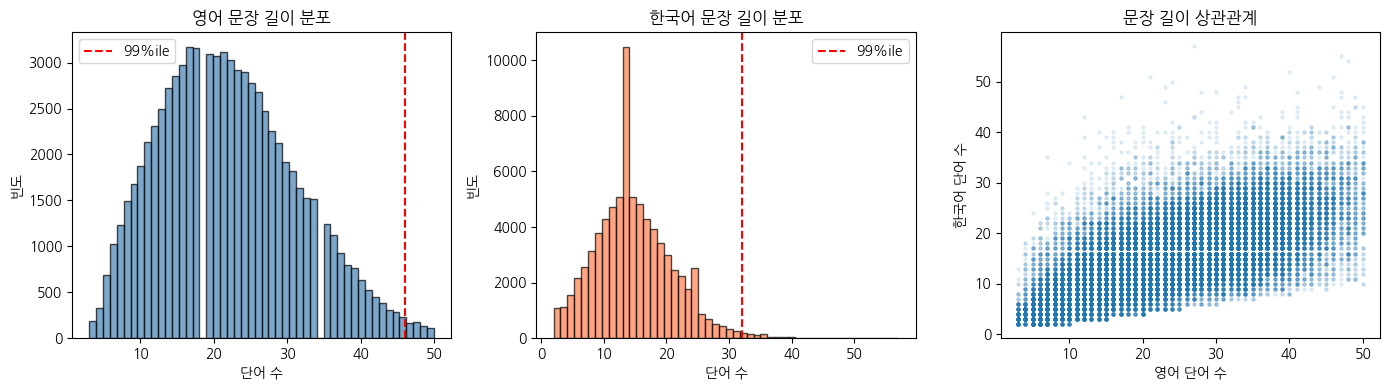


EDA 완료: 94,123 -> 77,448 문장 쌍


In [19]:
# Load data
print("데이터 로드 중...")
eng_raw, kor_raw = load_data(cfg.eng_train_path, cfg.kor_train_path)

# EDA + Cleaning
df_clean = perform_eda(eng_raw, kor_raw)

# Extract cleaned data
src_data = df_clean['kor'].tolist()  # Korean = source
tgt_data = df_clean['eng'].tolist()  # English = target

In [20]:
# Split data
print("\n데이터 분할...")
train_src, temp_src, train_tgt, temp_tgt = train_test_split(
    src_data, tgt_data, train_size=cfg.train_ratio, random_state=cfg.seed
)
val_src, test_src, val_tgt, test_tgt = train_test_split(
    temp_src, temp_tgt, test_size=0.5, random_state=cfg.seed
)

print(f"Train: {len(train_src):,}")
print(f"Val:   {len(val_src):,}")
print(f"Test:  {len(test_src):,}")


데이터 분할...
Train: 61,958
Val:   7,745
Test:  7,745


In [21]:
# Back-Translation (Optional)
if cfg.use_back_translation:
    train_src, train_tgt = augment_train_data_bt(train_src, train_tgt, cfg.bt_ratio)
else:
    print("\nBack-translation 비활성화 (use_back_translation=False)")

Back-Translation 데이터 증강
증강 비율: 30.0%

모델 로드: Helsinki-NLP/opus-mt-ko-en
모델 로드: Helsinki-NLP/opus-mt-tc-big-en-ko
모델 로드 완료!

증강 대상: 18,587개 문장


Back-Translation: 100%|██████████| 1162/1162 [25:13<00:00,  1.30s/it]


증강 완료: 18,587개 문장 생성

증강 결과:
  원본: 61,958 -> 증강 후: 80,545
  증강 비율: 1.30x


## Step 2: Train Tokenizers

In [22]:
# Train tokenizers
print("\nTokenizer 학습...")

kor_model_path = f"{cfg.kor_tokenizer_prefix}.model"
eng_model_path = f"{cfg.eng_tokenizer_prefix}.model"

if not os.path.exists(kor_model_path):
    train_sentencepiece(train_src, cfg.kor_tokenizer_prefix, cfg.vocab_size_src)
else:
    print(f"기존 모델 로드: {kor_model_path}")

if not os.path.exists(eng_model_path):
    train_sentencepiece(train_tgt, cfg.eng_tokenizer_prefix, cfg.vocab_size_tgt)
else:
    print(f"기존 모델 로드: {eng_model_path}")

vocab_src = SPTokenizer(kor_model_path)
vocab_tgt = SPTokenizer(eng_model_path)

print(f"\nVocab: src={len(vocab_src):,}, tgt={len(vocab_tgt):,}")


Tokenizer 학습...
기존 모델 로드: ./tokenizers/sp_kor.model
기존 모델 로드: ./tokenizers/sp_eng.model

Vocab: src=16,000, tgt=16,000


## Step 3: Create DataLoaders

In [23]:
# Create datasets & dataloaders
print("\nDataset 생성...")

train_dataset = TranslationDataset(train_src, train_tgt, vocab_src, vocab_tgt, cfg.max_length_src, cfg.max_length_tgt)
val_dataset = TranslationDataset(val_src, val_tgt, vocab_src, vocab_tgt, cfg.max_length_src, cfg.max_length_tgt)
test_dataset = TranslationDataset(test_src, test_tgt, vocab_src, vocab_tgt, cfg.max_length_src, cfg.max_length_tgt)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn, num_workers=cfg.num_workers)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn, num_workers=cfg.num_workers)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn, num_workers=cfg.num_workers)

print(f"Batches: train={len(train_loader)}, val={len(val_loader)}, test={len(test_loader)}")


Dataset 생성...
Batches: train=315, val=31, test=31


## Step 4: Initialize Model

In [24]:
# Initialize model
print("\n모델 초기화...")

model = Transformer(vocab_src, vocab_tgt, cfg).to(device)

print(f"파라미터 수: {model.count_parameters():,}")
print(f"구조: {cfg.emb_dim}d, {cfg.num_layers}L, {cfg.num_heads}H, {cfg.ffn_dim} FFN")


모델 초기화...
파라미터 수: 15,553,536
구조: 256d, 4L, 4H, 1024 FFN


## Step 5: Train

In [25]:
# Train
trainer = Trainer(model, train_loader, val_loader, vocab_src, vocab_tgt, cfg, device)
history = trainer.train()

Training Started



--------------------------------------------------
[Sample Translation]
SRC:  오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT:  asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED: order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order order
--------------------------------------------------

Epoch 01/100 (108s)
  Train Loss: 53.9023 | PPL: 256722014935398999916544.00
  Val   Loss: 38.2256 | PPL: 39917500387673400.00
  [Best model saved]



Epoch 02/100 (108s)
  Train Loss: 24.1346 | PPL: 30306284187.11
  Val   Loss: 7.0222 | PPL: 1121.29
  [Best model saved]



Epoch 03/100 (109s)
  Train Loss: 7.5931 | PPL: 1984.40
  Val   Loss: 3.9413 | PPL: 51.49
  [Best model saved]



Epoch 04/100 (109s)
  Train Loss: 4.1537 | PPL: 63.67
  Val   Loss: 3.4908 | PPL: 32.81
  [Best model saved]



Epoch 05/100 (109s)
  Train Loss: 3.6497 | PPL: 38.46
  Val   Loss: 3.3467 | PPL: 28.41
  [Best model saved]



Epoch 06/100 (109s)
  Train Loss: 3.5162 | PPL: 33.66
  Val   Loss: 3.3779 | PPL: 29.31
  Patience: 1/10



Epoch 07/100 (109s)
  Train Loss: 3.4456 | PPL: 31.36
  Val   Loss: 3.3821 | PPL: 29.43
  Patience: 2/10



Epoch 08/100 (109s)
  Train Loss: 3.4106 | PPL: 30.28
  Val   Loss: 3.3242 | PPL: 27.78
  [Best model saved]



Epoch 09/100 (109s)
  Train Loss: 3.3964 | PPL: 29.86
  Val   Loss: 3.4557 | PPL: 31.68
  Patience: 1/10



Epoch 10/100 (109s)
  Train Loss: 3.3855 | PPL: 29.53
  Val   Loss: 3.3375 | PPL: 28.15
  Patience: 2/10



--------------------------------------------------
[Sample Translation]
SRC:  오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT:  asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
--------------------------------------------------

Epoch 11/100 (109s)
  Train Loss: 3.3710 | PPL: 29.11
  Val   Loss: 3.5030 | PPL: 33.22
  Patience: 3/10



Epoch 12/100 (109s)
  Train Loss: 3.3759 | PPL: 29.25
  Val   Loss: 3.3564 | PPL: 28.69
  Patience: 4/10



Epoch 13/100 (109s)
  Train Loss: 3.3628 | PPL: 28.87
  Val   Loss: 3.3906 | PPL: 29.68
  Patience: 5/10



Epoch 14/100 (108s)
  Train Loss: 3.3620 | PPL: 28.85
  Val   Loss: 3.3685 | PPL: 29.03
  Patience: 6/10



Epoch 15/100 (108s)
  Train Loss: 3.3366 | PPL: 28.12
  Val   Loss: 3.3332 | PPL: 28.03
  Patience: 7/10



Epoch 16/100 (109s)
  Train Loss: 3.3346 | PPL: 28.07
  Val   Loss: 3.3287 | PPL: 27.90
  Patience: 8/10



Epoch 17/100 (109s)
  Train Loss: 3.3239 | PPL: 27.77
  Val   Loss: 3.3213 | PPL: 27.70
  [Best model saved]



Epoch 18/100 (109s)
  Train Loss: 3.3186 | PPL: 27.62
  Val   Loss: 3.3222 | PPL: 27.72
  Patience: 1/10



Epoch 19/100 (109s)
  Train Loss: 3.3098 | PPL: 27.38
  Val   Loss: 3.3308 | PPL: 27.96
  Patience: 2/10



Epoch 20/100 (108s)
  Train Loss: 3.3165 | PPL: 27.56
  Val   Loss: 3.3361 | PPL: 28.11
  Patience: 3/10



--------------------------------------------------
[Sample Translation]
SRC:  오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT:  asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
--------------------------------------------------

Epoch 21/100 (109s)
  Train Loss: 3.3146 | PPL: 27.51
  Val   Loss: 3.3142 | PPL: 27.50
  [Best model saved]



Epoch 22/100 (109s)
  Train Loss: 3.3112 | PPL: 27.42
  Val   Loss: 3.3334 | PPL: 28.03
  Patience: 1/10



Epoch 23/100 (109s)
  Train Loss: 3.3142 | PPL: 27.50
  Val   Loss: 3.3149 | PPL: 27.52
  Patience: 2/10



Epoch 24/100 (108s)
  Train Loss: 3.3023 | PPL: 27.17
  Val   Loss: 3.3092 | PPL: 27.36
  [Best model saved]



Epoch 25/100 (109s)
  Train Loss: 3.2873 | PPL: 26.77
  Val   Loss: 3.3045 | PPL: 27.24
  [Best model saved]



Epoch 26/100 (109s)
  Train Loss: 3.2900 | PPL: 26.84
  Val   Loss: 3.2971 | PPL: 27.03
  [Best model saved]



Epoch 27/100 (109s)
  Train Loss: 3.2793 | PPL: 26.56
  Val   Loss: 3.2904 | PPL: 26.85
  [Best model saved]



Epoch 28/100 (108s)
  Train Loss: 3.2788 | PPL: 26.54
  Val   Loss: 3.2811 | PPL: 26.60
  [Best model saved]



Epoch 29/100 (109s)
  Train Loss: 3.2705 | PPL: 26.32
  Val   Loss: 3.2760 | PPL: 26.47
  [Best model saved]



Epoch 30/100 (109s)
  Train Loss: 3.2588 | PPL: 26.02
  Val   Loss: 3.2520 | PPL: 25.84
  [Best model saved]



--------------------------------------------------
[Sample Translation]
SRC:  오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT:  asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
--------------------------------------------------

Epoch 31/100 (108s)
  Train Loss: 3.2582 | PPL: 26.00
  Val   Loss: 3.2472 | PPL: 25.72
  [Best model saved]



Epoch 32/100 (108s)
  Train Loss: 3.2440 | PPL: 25.64
  Val   Loss: 3.2421 | PPL: 25.59
  [Best model saved]



Epoch 33/100 (109s)
  Train Loss: 3.2340 | PPL: 25.38
  Val   Loss: 3.2312 | PPL: 25.31
  [Best model saved]



Epoch 34/100 (109s)
  Train Loss: 3.2198 | PPL: 25.02
  Val   Loss: 3.2189 | PPL: 25.00
  [Best model saved]



Epoch 35/100 (109s)
  Train Loss: 3.2244 | PPL: 25.14
  Val   Loss: 3.2154 | PPL: 24.91
  [Best model saved]



Epoch 36/100 (109s)
  Train Loss: 3.2118 | PPL: 24.82
  Val   Loss: 3.2052 | PPL: 24.66
  [Best model saved]



Epoch 37/100 (109s)
  Train Loss: 3.1971 | PPL: 24.46
  Val   Loss: 3.1988 | PPL: 24.50
  [Best model saved]



Epoch 38/100 (109s)
  Train Loss: 3.1974 | PPL: 24.47
  Val   Loss: 3.1899 | PPL: 24.29
  [Best model saved]



Epoch 39/100 (109s)
  Train Loss: 3.1868 | PPL: 24.21
  Val   Loss: 3.1865 | PPL: 24.20
  [Best model saved]



Epoch 40/100 (109s)
  Train Loss: 3.1802 | PPL: 24.05
  Val   Loss: 3.1781 | PPL: 24.00
  [Best model saved]



--------------------------------------------------
[Sample Translation]
SRC:  오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT:  asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
--------------------------------------------------

Epoch 41/100 (109s)
  Train Loss: 3.1763 | PPL: 23.96
  Val   Loss: 3.1731 | PPL: 23.88
  [Best model saved]



Epoch 42/100 (109s)
  Train Loss: 3.1739 | PPL: 23.90
  Val   Loss: 3.1670 | PPL: 23.74
  [Best model saved]



Epoch 43/100 (109s)
  Train Loss: 3.1620 | PPL: 23.62
  Val   Loss: 3.1677 | PPL: 23.75
  Patience: 1/10



Epoch 44/100 (109s)
  Train Loss: 3.1658 | PPL: 23.71
  Val   Loss: 3.1665 | PPL: 23.72
  Patience: 2/10



Epoch 45/100 (109s)
  Train Loss: 3.1570 | PPL: 23.50
  Val   Loss: 3.1597 | PPL: 23.56
  [Best model saved]



Epoch 46/100 (108s)
  Train Loss: 3.1632 | PPL: 23.65
  Val   Loss: 3.1546 | PPL: 23.44
  [Best model saved]



Epoch 47/100 (109s)
  Train Loss: 3.1600 | PPL: 23.57
  Val   Loss: 3.1556 | PPL: 23.47
  Patience: 1/10



Epoch 48/100 (109s)
  Train Loss: 3.1528 | PPL: 23.40
  Val   Loss: 3.1615 | PPL: 23.61
  Patience: 2/10



Epoch 49/100 (109s)
  Train Loss: 3.1532 | PPL: 23.41
  Val   Loss: 3.1489 | PPL: 23.31
  [Best model saved]



Epoch 50/100 (108s)
  Train Loss: 3.1549 | PPL: 23.45
  Val   Loss: 3.1482 | PPL: 23.29
  Patience: 1/10



--------------------------------------------------
[Sample Translation]
SRC:  오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT:  asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
--------------------------------------------------

Epoch 51/100 (109s)
  Train Loss: 3.1516 | PPL: 23.37
  Val   Loss: 3.1418 | PPL: 23.15
  [Best model saved]



Epoch 52/100 (109s)
  Train Loss: 3.1438 | PPL: 23.19
  Val   Loss: 3.1408 | PPL: 23.12
  [Best model saved]



Epoch 53/100 (109s)
  Train Loss: 3.1578 | PPL: 23.52
  Val   Loss: 3.1490 | PPL: 23.31
  Patience: 1/10



Epoch 54/100 (109s)
  Train Loss: 3.1330 | PPL: 22.94
  Val   Loss: 3.1394 | PPL: 23.09
  [Best model saved]



Epoch 55/100 (109s)
  Train Loss: 3.1400 | PPL: 23.10
  Val   Loss: 3.1376 | PPL: 23.05
  [Best model saved]



Epoch 56/100 (109s)
  Train Loss: 3.1392 | PPL: 23.08
  Val   Loss: 3.1366 | PPL: 23.02
  [Best model saved]



Epoch 57/100 (108s)
  Train Loss: 3.1365 | PPL: 23.02
  Val   Loss: 3.1344 | PPL: 22.97
  [Best model saved]



Epoch 58/100 (109s)
  Train Loss: 3.1272 | PPL: 22.81
  Val   Loss: 3.1318 | PPL: 22.92
  [Best model saved]



Epoch 59/100 (108s)
  Train Loss: 3.1301 | PPL: 22.88
  Val   Loss: 3.1311 | PPL: 22.90
  Patience: 1/10



Epoch 60/100 (109s)
  Train Loss: 3.1273 | PPL: 22.81
  Val   Loss: 3.1272 | PPL: 22.81
  [Best model saved]



--------------------------------------------------
[Sample Translation]
SRC:  오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT:  asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
--------------------------------------------------

Epoch 61/100 (109s)
  Train Loss: 3.1195 | PPL: 22.64
  Val   Loss: 3.1244 | PPL: 22.75
  [Best model saved]



Epoch 62/100 (109s)
  Train Loss: 3.1196 | PPL: 22.64
  Val   Loss: 3.1239 | PPL: 22.73
  Patience: 1/10



Epoch 63/100 (109s)
  Train Loss: 3.1240 | PPL: 22.74
  Val   Loss: 3.1248 | PPL: 22.75
  Patience: 2/10



Epoch 64/100 (109s)
  Train Loss: 3.1213 | PPL: 22.68
  Val   Loss: 3.1231 | PPL: 22.72
  [Best model saved]



Epoch 65/100 (109s)
  Train Loss: 3.1175 | PPL: 22.59
  Val   Loss: 3.1218 | PPL: 22.69
  [Best model saved]



Epoch 66/100 (109s)
  Train Loss: 3.1112 | PPL: 22.45
  Val   Loss: 3.1189 | PPL: 22.62
  [Best model saved]



Epoch 67/100 (109s)
  Train Loss: 3.1179 | PPL: 22.60
  Val   Loss: 3.1168 | PPL: 22.57
  [Best model saved]



Epoch 68/100 (109s)
  Train Loss: 3.1181 | PPL: 22.60
  Val   Loss: 3.1153 | PPL: 22.54
  [Best model saved]



Epoch 69/100 (109s)
  Train Loss: 3.1148 | PPL: 22.53
  Val   Loss: 3.1188 | PPL: 22.62
  Patience: 1/10



Epoch 70/100 (109s)
  Train Loss: 3.1154 | PPL: 22.54
  Val   Loss: 3.1138 | PPL: 22.51
  [Best model saved]



--------------------------------------------------
[Sample Translation]
SRC:  오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT:  asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
--------------------------------------------------

Epoch 71/100 (109s)
  Train Loss: 3.1215 | PPL: 22.68
  Val   Loss: 3.1126 | PPL: 22.48
  [Best model saved]



Epoch 72/100 (109s)
  Train Loss: 3.1066 | PPL: 22.34
  Val   Loss: 3.1132 | PPL: 22.49
  Patience: 1/10



Epoch 73/100 (109s)
  Train Loss: 3.1077 | PPL: 22.37
  Val   Loss: 3.1109 | PPL: 22.44
  [Best model saved]



Epoch 74/100 (109s)
  Train Loss: 3.1121 | PPL: 22.47
  Val   Loss: 3.1097 | PPL: 22.41
  [Best model saved]



Epoch 75/100 (109s)
  Train Loss: 3.1086 | PPL: 22.39
  Val   Loss: 3.1150 | PPL: 22.53
  Patience: 1/10



Epoch 76/100 (109s)
  Train Loss: 3.1079 | PPL: 22.37
  Val   Loss: 3.1064 | PPL: 22.34
  [Best model saved]



Epoch 77/100 (109s)
  Train Loss: 3.1095 | PPL: 22.41
  Val   Loss: 3.1057 | PPL: 22.32
  Patience: 1/10



Epoch 78/100 (109s)
  Train Loss: 3.1101 | PPL: 22.42
  Val   Loss: 3.1058 | PPL: 22.33
  Patience: 2/10



Epoch 79/100 (109s)
  Train Loss: 3.0972 | PPL: 22.14
  Val   Loss: 3.1038 | PPL: 22.28
  [Best model saved]



Epoch 80/100 (109s)
  Train Loss: 3.1053 | PPL: 22.32
  Val   Loss: 3.1038 | PPL: 22.28
  Patience: 1/10



--------------------------------------------------
[Sample Translation]
SRC:  오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT:  asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
--------------------------------------------------

Epoch 81/100 (109s)
  Train Loss: 3.1050 | PPL: 22.31
  Val   Loss: 3.1018 | PPL: 22.24
  [Best model saved]



Epoch 82/100 (109s)
  Train Loss: 3.1034 | PPL: 22.27
  Val   Loss: 3.1026 | PPL: 22.26
  Patience: 1/10



Epoch 83/100 (109s)
  Train Loss: 3.0928 | PPL: 22.04
  Val   Loss: 3.1030 | PPL: 22.26
  Patience: 2/10



Epoch 84/100 (108s)
  Train Loss: 3.1012 | PPL: 22.22
  Val   Loss: 3.0998 | PPL: 22.19
  [Best model saved]



Epoch 85/100 (109s)
  Train Loss: 3.0957 | PPL: 22.10
  Val   Loss: 3.0969 | PPL: 22.13
  [Best model saved]



Epoch 86/100 (109s)
  Train Loss: 3.0949 | PPL: 22.08
  Val   Loss: 3.0953 | PPL: 22.09
  [Best model saved]



Epoch 87/100 (109s)
  Train Loss: 3.0953 | PPL: 22.09
  Val   Loss: 3.0937 | PPL: 22.06
  [Best model saved]



Epoch 88/100 (109s)
  Train Loss: 3.0995 | PPL: 22.19
  Val   Loss: 3.0932 | PPL: 22.05
  Patience: 1/10



Epoch 89/100 (109s)
  Train Loss: 3.0984 | PPL: 22.16
  Val   Loss: 3.0920 | PPL: 22.02
  [Best model saved]



Epoch 90/100 (109s)
  Train Loss: 3.0913 | PPL: 22.01
  Val   Loss: 3.0915 | PPL: 22.01
  Patience: 1/10



--------------------------------------------------
[Sample Translation]
SRC:  오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT:  asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
--------------------------------------------------

Epoch 91/100 (109s)
  Train Loss: 3.0912 | PPL: 22.00
  Val   Loss: 3.0894 | PPL: 21.96
  [Best model saved]



Epoch 92/100 (109s)
  Train Loss: 3.0889 | PPL: 21.95
  Val   Loss: 3.0921 | PPL: 22.02
  Patience: 1/10



Epoch 93/100 (109s)
  Train Loss: 3.0891 | PPL: 21.96
  Val   Loss: 3.0904 | PPL: 21.99
  Patience: 2/10



Epoch 94/100 (108s)
  Train Loss: 3.0899 | PPL: 21.98
  Val   Loss: 3.0880 | PPL: 21.93
  [Best model saved]



Epoch 95/100 (109s)
  Train Loss: 3.0875 | PPL: 21.92
  Val   Loss: 3.0872 | PPL: 21.92
  Patience: 1/10



Epoch 96/100 (109s)
  Train Loss: 3.0884 | PPL: 21.94
  Val   Loss: 3.0878 | PPL: 21.93
  Patience: 2/10



Epoch 97/100 (109s)
  Train Loss: 3.0886 | PPL: 21.95
  Val   Loss: 3.0856 | PPL: 21.88
  [Best model saved]



Epoch 98/100 (109s)
  Train Loss: 3.0848 | PPL: 21.86
  Val   Loss: 3.0853 | PPL: 21.87
  Patience: 1/10



Epoch 99/100 (109s)
  Train Loss: 3.0774 | PPL: 21.70
  Val   Loss: 3.0844 | PPL: 21.85
  [Best model saved]



Epoch 100/100 (108s)
  Train Loss: 3.0860 | PPL: 21.89
  Val   Loss: 3.0817 | PPL: 21.80
  [Best model saved]

Training complete! Best: epoch 100, loss 3.0817


## Step 6: Evaluate on Test Set

In [26]:
# Evaluate
print("\nTest 데이터 평가...")

checkpoint = torch.load(cfg.model_save_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

criterion = LabelSmoothingLoss(len(vocab_tgt), cfg.label_smoothing, vocab_tgt.PAD_ID)
test_loss = evaluate(model, test_loader, criterion, device)
test_ppl = math.exp(min(test_loss, 100))

print(f"Test Loss: {test_loss:.4f}")
print(f"Test PPL:  {test_ppl:.2f}")

print("\nBLEU 계산 중...")
test_bleu = evaluate_bleu(model, test_loader, vocab_src, vocab_tgt, device, num_samples=500, use_beam_search=True)
print(f"Test BLEU: {test_bleu:.2f}")


Test 데이터 평가...
Test Loss: 3.0476
Test PPL:  21.06

BLEU 계산 중...


Test BLEU: 0.00


## Step 7: Visualize Training

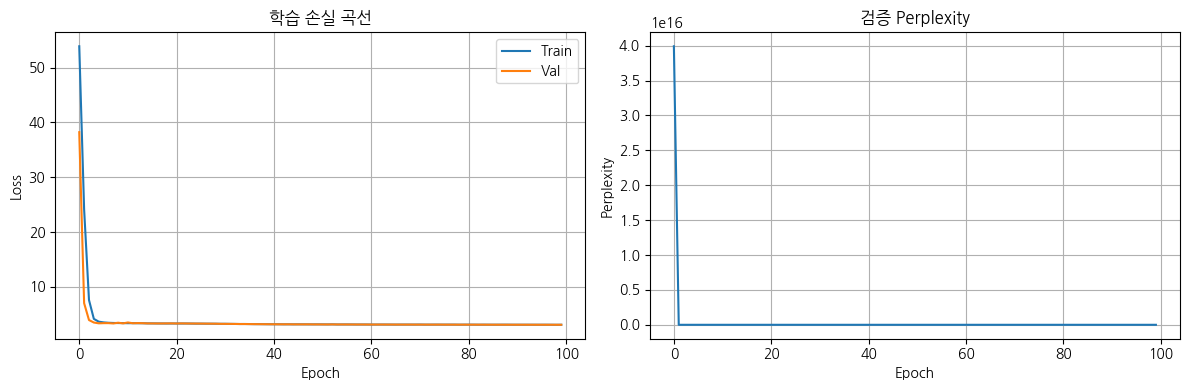

In [27]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('학습 손실 곡선')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['val_ppl'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('검증 Perplexity')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Step 8: Interactive Translation

In [37]:
# Translation demo
print("번역 데모")
print("=" * 60)

test_sentences = ['오바마 대통령은 말했다',
  '개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"',
'모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.',
'그러나 이것은 또한 책상도 필요로 하지 않는다.',
'79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.',
'정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.',
'이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.',
'국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.',
'이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.',
'"결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."',
'연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.',
'약 200600밀리그램의, 비슷한 분량의 카페인은 또한 육체적 지구력을 강화시키는 데 효과적인 것 같으며, 특히 고도가 높은 곳에서 약해진 육체적 지구력을 일부 회복시켜주는 데 유용하다는 것이 이번 연구에서 밝혀졌다.',
'의약 연구소는 정부에 과학 문제에 관해 자문하기 위해 의회가 설립 인가를 내어 준 민간 단체인 국립 과학 학회의 부속 단체이다.',
'아시아에서의 왕성한 수요 덕분에 일본의 수출이 9월에 연속 6개월간 증가하여, 무역 흑자가 1조550억엔(84억7,000만달러)으로 늘어났다고 재무성이 발표했다.',
'그러나 침체되고 있는 미국 경제와 국내 수요의 약세 전망이 향후 수개월 동안의 낙관론을 어둡게 했다.',
'특수 부대가 극장 건물로 공격해 들어가면서, 러시아인이 아닌 75명의 외국인과 25명의 어린이 전부를 포함해 750명 이상의 인질들이 구출되었다.',
'러시아 특수 부대는 극장으로 공격해 들어가기 전에 신경 독가스를 사용했다.',
'많은 인질들이 화학 가스의 영향으로 고통을 겪으며 병원으로 옮겨졌다.',
'과거 노조 지도자였던 루이스 이나시오 룰라 다 실바가 브라질의 대통령 선거 결선 투표에서 압승을 거두면서, 라틴 아메리카 최대 국가로서는 좌파로의 역사적인 전환을 맞이하게 되었다.'
]


for sent in test_sentences:
    translation = translate(sent, model, vocab_src, vocab_tgt, device, use_beam_search=True)
    print(f"KO: {sent}")
    print(f"EN: {translation}")
    print("-" * 60)

번역 데모
KO: 오바마 대통령은 말했다
EN: the 100000000000000000000000000000000000000000000000
------------------------------------------------------------
KO: 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
EN: the 100000000000000000000000000000000000000000000000
------------------------------------------------------------
KO: 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
EN: the 100000000000000000000000000000000000000000000000
------------------------------------------------------------
KO: 그러나 이것은 또한 책상도 필요로 하지 않는다.
EN: the 100000000000000000000000000000000000000000000000
------------------------------------------------------------
KO: 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
EN: the 100000000000000000000000000000000000000000000000
------------------------------------------------------------
KO: 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
EN: the 1000000000000000000000000000000

## Step 9: Attention Visualization

Attention Map 시각화

입력: 오늘 날씨가 좋습니다.
Input:  오늘 날씨가 좋습니다.
Output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

[Head별 Attention Map]


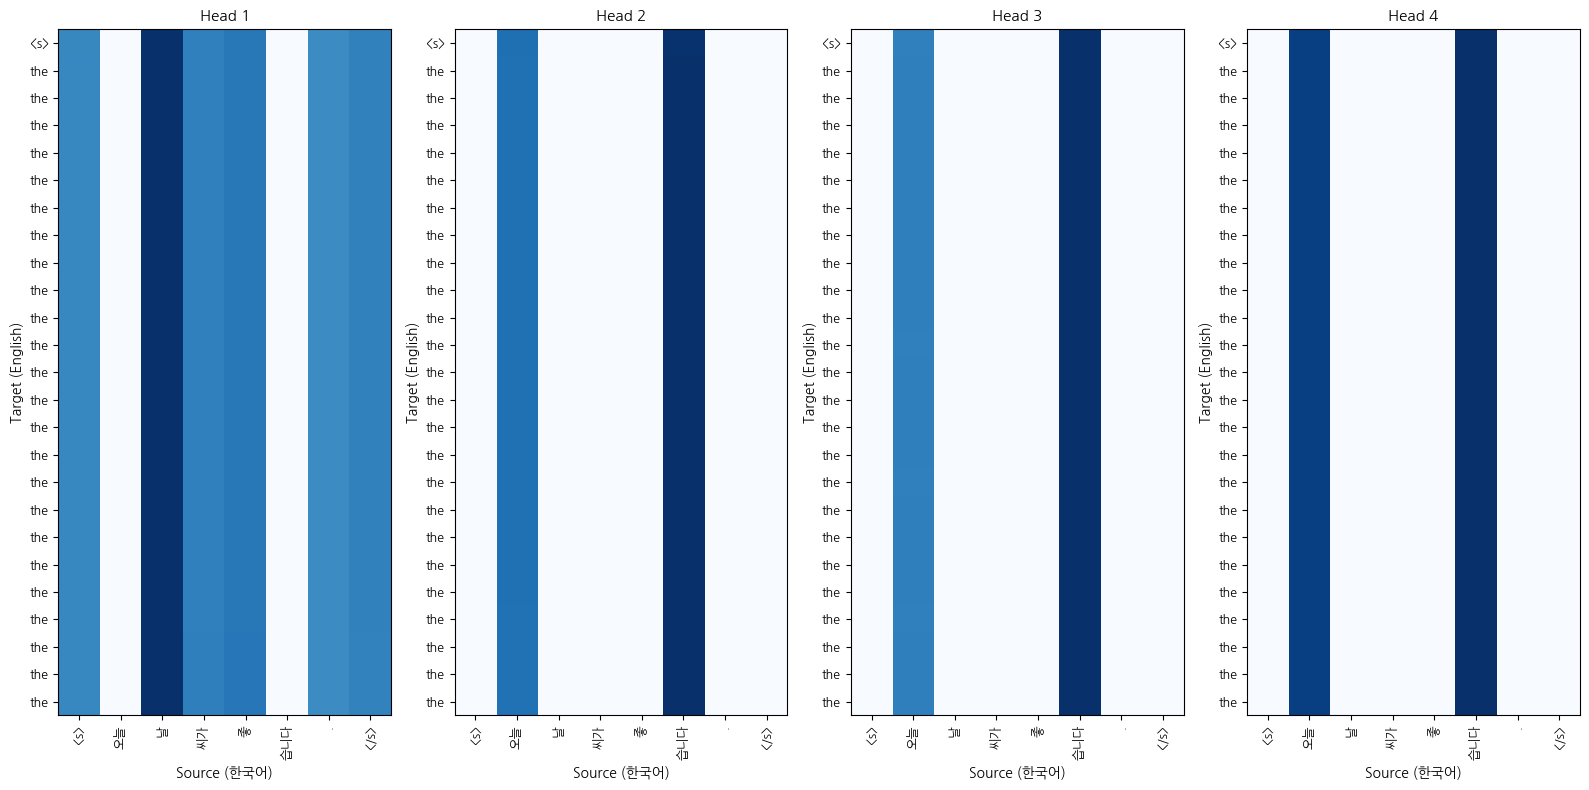


[평균 Attention Map]


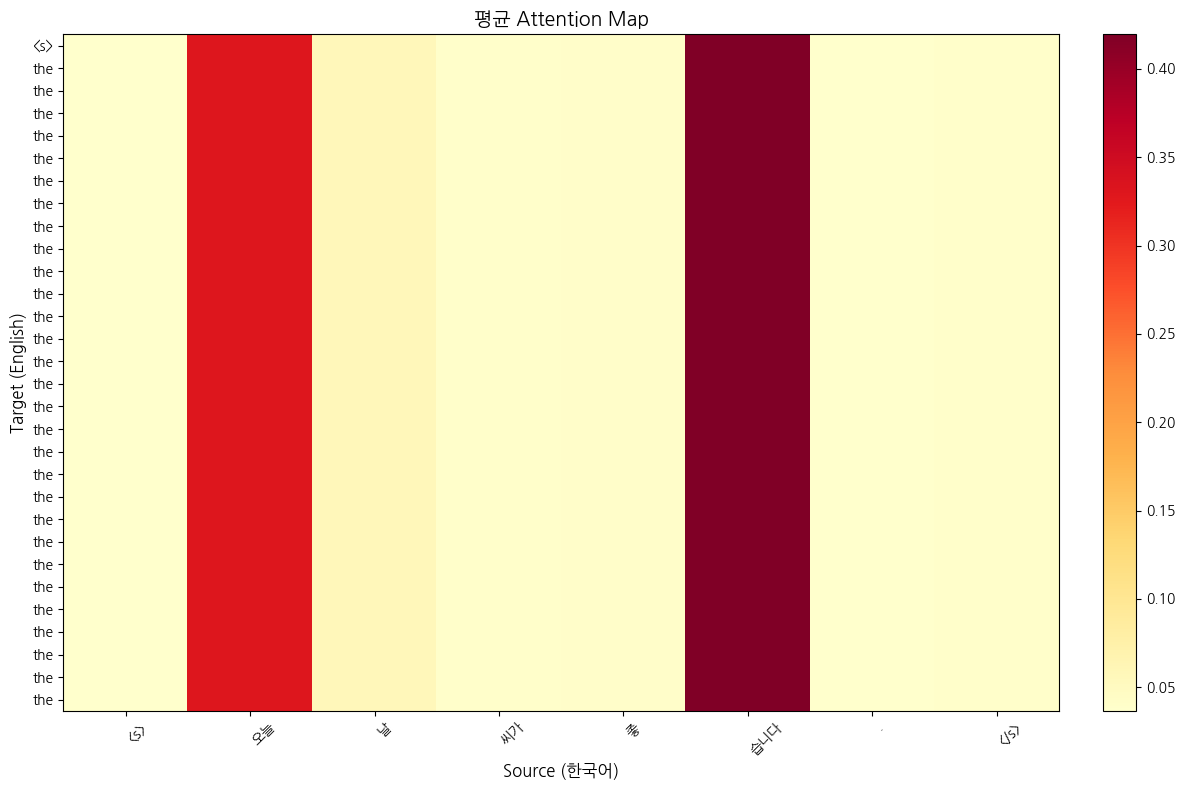


입력: 인공지능 기술이 빠르게 발전하고 있습니다.
Input:  인공지능 기술이 빠르게 발전하고 있습니다.
Output: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

[Head별 Attention Map]


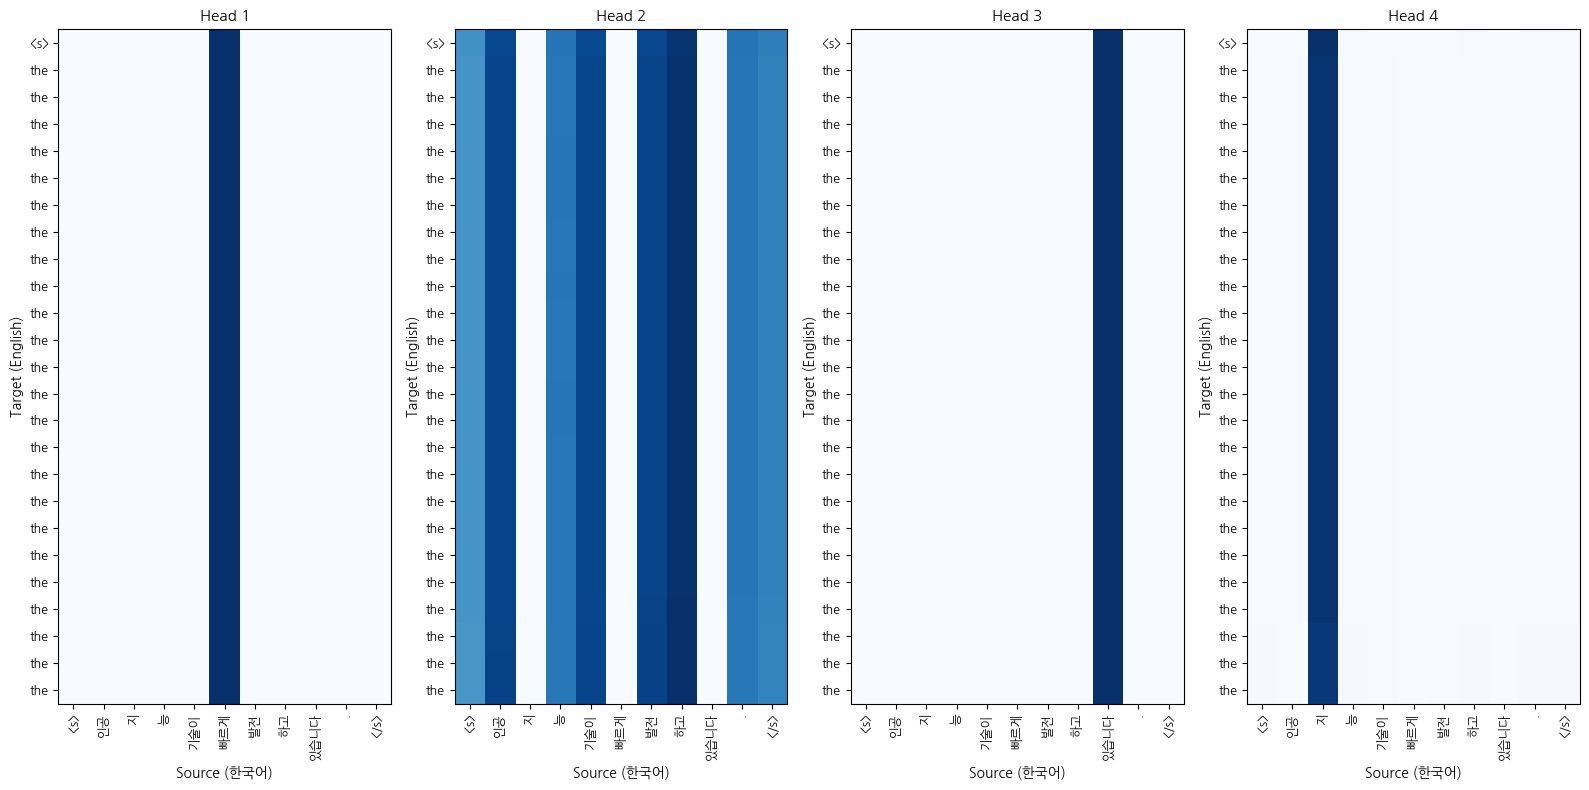


[평균 Attention Map]


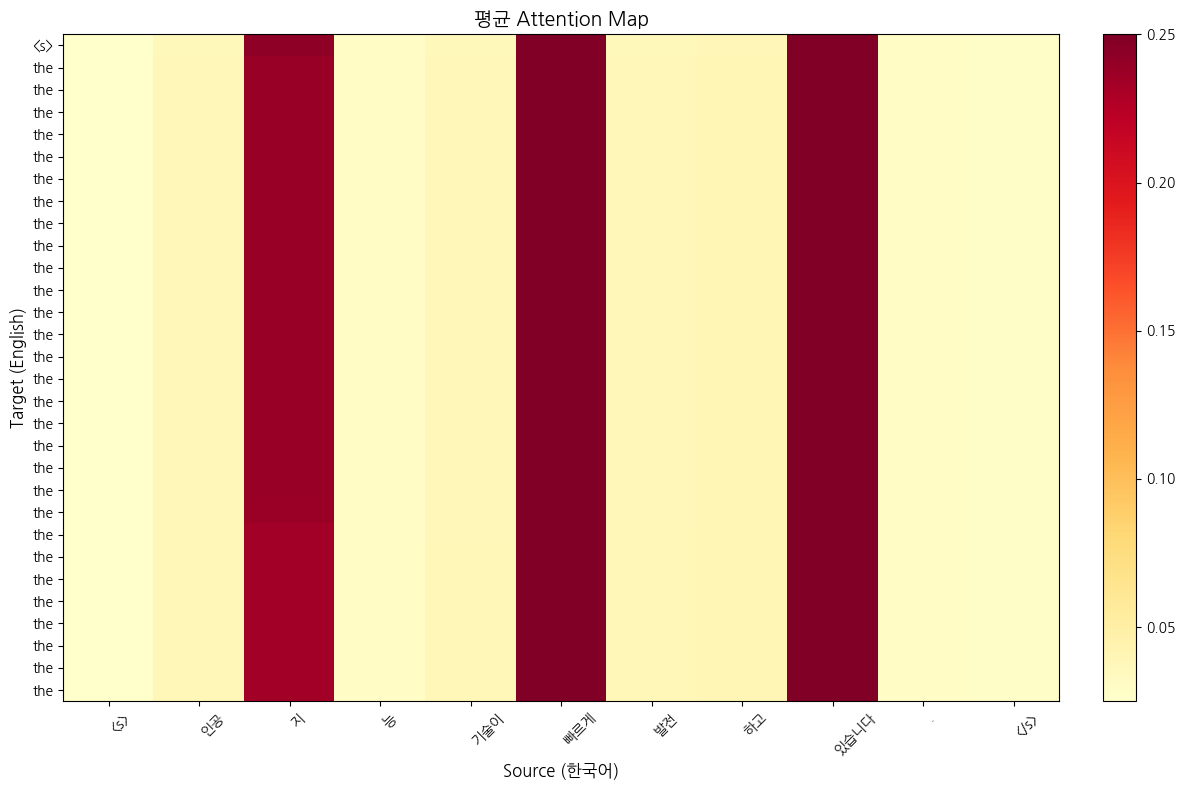

In [29]:
# Attention visualization
print("Attention Map 시각화")
print("=" * 60)

sample_sentences = [
    "오늘 날씨가 좋습니다.",
    "인공지능 기술이 빠르게 발전하고 있습니다.",
]

for sent in sample_sentences:
    print(f"\n입력: {sent}")
    visualize_translation_attention(sent, model, vocab_src, vocab_tgt, device)

In [36]:
# Custom translation
custom_sentence = "여기에 번역할 한국어 문장을 입력하세요."
translation = translate(custom_sentence, model, vocab_src, vocab_tgt, device)
print(f"Input:  {custom_sentence}")
print(f"Output: {translation}")

Input:  여기에 번역할 한국어 문장을 입력하세요.
Output: the 100000000000000000000000000000000000000000000000


회고:



이래저래 실험을 진행했다.

결론적으로 모델 구현을 아무리 논문과 비슷하게 해도 제대로 된 번역을 하는 모습은 보이지 않았다.



임베딩의 차원, 레이어의 갯수, 여러 learning rate, batch size, 데이터 증강 등등 많이 수정하고 바꿔봐도 신통한 결과는 없지 못했다. 

흥미로운 점은 나는 놓치지 않고 구현한 요소 (weight tying & Transformer's learning rate scheduler)가 없는 코드가 나보다 결과가 더 좋았다는 점이다.

차이점은 그 코드의 경우 alphabet 기반의 언어 번역 (독일어 => 영어) 였지만 나는 한영 번역이라 서로 완전히 다른 언어체계 및 문자 시스템으로 왔다 갔다 매핑하는게 모델에게 있어서 큰 난관이지 않았을까 싶다.

실제로 혼자서 진행했던 트랜스포머 챗봇 프로젝트의 경우 val loss가 2점대 였음에도 불구하고 괜찮은 답변을 했었다 (ex. 감기에 걸린거 같아 => 병원에 가세요). 한국어 => 한국어라 같은 언어이기에 모델이

수월하게 진행했을것이라 생각된다 (벡터공간이 유사하거나 (독영) 매우 다르거나 (한영)). 



다만, 따로 submission.ipynb에서 진행했던 프로젝트 같은 경우 이정도로 결과가 처참하진 않았다

원문 (korean): 오바마 대통령은 말했다

번역 (english): the u.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s

korean: 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.

eng: "we's very, i't said.

korean: 과거 노조 지도자였던 루이스 이나시오 룰라 다 실바가 브라질의 대통령 선거 결선 투표에서 압승을 거두면서, 라틴 아메리카 최대 국가로서는 좌파로의 역사적인 전환을 맞이하게 되었다.

eng: "i's a lot, and i't said.



Wernicke's area에 손상이라도 온듯이 동문서답을 하는듯 하지만 기존 the 1000000000000000000000같은 답변보다는 좀 더 개선된 모습을 관찰할수 있다. 

차이점은 다음과 같다: 



KoEn - Encoder/Decoder가 자체 embedding 포함:

class Encoder(nn.Module):

    def __init__(self, vocab_size, emb_dim, ...):

        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx)  #

        self.pos_enc = SinusoidalPositionalEncoding(emb_dim)

최종본 - 외부에서 embedding 주입:

class Encoder(nn.Module):

    def __init__(self, config, embed_tokens):  

        self.embed_tokens = embed_tokens

        self.embed_positions = SinusoidalPositionalEmbedding(...)



즉, 임베딩을 자체적으로 진행하느냐 혹은 기존에 있는 임베딩을 사용하느냐의 차이에서 이와같은 차이가 난것으로 보인다. 

실제로 깃헙에 찾은 코드 중에 한영 번역기로 성능이 좋은 모델의 경우 pretrained tokenizer를 사용한걸 보았다. 

비록 임베딩이랑 별개의 요소이지만 결국 토큰화와 워드 임베딩 등 모델에 들어가기전에 우리가 진행하는 요소들이 성능에 큰 영향을 미친다. 

또한 여담이지만 역번역을 진행하니 오히려 성능이 저하되는 모습을 볼수있었다. 차라리 안했던 최종본의 결과물이 좋았다는건 의미심장하다. 오히려 노이즈만 추가하고 본래 데이터의 분포만 왜곡한게 아닐까? 

마지막으로 데이터의 질이 애초에 이런 번역 태스크에 알맞았는지 의문이다. 





SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.

TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."

PRED tokens: [2, 265, 707, 768, 336, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443]...



샘플 영어: new york (cnn) the consumer product safety commission, in cooperation with mattel inc., announced late tuesday that it is recalling about 700,000 chinese-made toys that have excessive amounts of lead paint.

인코딩: [454, 1233, 493, 802, 15987, 265, 3675, 3815, 2844, 1985, 15968, 284, 4431, 361, 10878, 526, 2438, 1342, 1563, 754]



샘플 한국어: 미국 유명 완구업체 마텔사와 협력하고 있는 소비자상품안전위원회는 4일(현지시간) 납성분의 페인트가 함유된 약 70만개의 중국 산 장난감을 리콜조치할 것이라 밝혔다.

인코딩: [313, 1404, 934, 14762, 1098, 13218, 1853, 2337, 288, 319, 4207, 14732, 15045, 5249, 3210, 14683, 14817, 14719, 14755, 379]



보면은 애초에 오번역이거나 혹은 영어에는 있는 내용이 한국어에는 없는 경우도 보인다 (민주당과 공화당의 지지, david axelrod, new york (cnn) late tuesday 4일 현지시간).
데이터만 따져보면 왜 챗봇이 더 성능이 좋았는지 이해가 간다. 챗봇 데이터는 심리상담 데이터로 Q&A에 맞춰서 이미 정제됬지만 이 데이터는 애초에 초월번역에 가까운 번역 혹은 오번역이기에 그럴것이다.